# Introduction

In this Task we will imagine that we are in a lab studying Clostridioides difficile. We are tasked with creating a set of gRNAs which will target an inserted plasmid (Addgene Plasmid 54622) expressing an enhanced GFP (EGFP). We will find a set of protospacers that are specific to the EGFP coding region and excluding those with a potental off-target effect within the Thermofilum genome.

In [1]:
import sys
sys.path.append('../')
import crseek
from crseek import utils
from crseek import estimators
from crseek import annotators

In [2]:
from Bio import SeqIO
from Bio import Seq
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set(style = 'white', font_scale=1.5)

import warnings
warnings.simplefilter('ignore', category = Seq.BiopythonWarning)

%matplotlib inline

# Load Sequences

Standard Biopython tools can be used to load the Clostridioides difficile 630, complete genome (RefSeq: NC_009089.1) and the AddGene plasmid.

In [3]:
with open('data/Clostridioides_difficile_630.gb') as handle:
    genome = list(SeqIO.parse(handle, 'genbank'))[0]
    
with open('data/addgene-plasmid-54622-sequence-158642.gbk') as handle:
    plasmid = list(SeqIO.parse(handle, 'genbank'))[0]

for rec in plasmid.features:
    if rec.qualifiers.get('product', [''])[0].startswith('enhanced GFP'):
        print('Found')
        egfp_feature = rec
        break
        
egfp_record = egfp_feature.extract(plasmid)

Found


# Extract possible targets

Using the EGFP sequence the `crisprtree` can extract all potential protospacers by finding all sequences upstream of a PAM sequence on each strand.

In [4]:
possible_targets = utils.extract_possible_targets(egfp_record, pams=('NGG',))   
print('%i possible targets' % len(possible_targets))

117 possible targets


# Exclude Off-targets

In order to avoid effecting the bacterium with the gRNA it is important to check for potential off-target effects in the C. diff genome. The `CFDEstimator` can be used to assess this likelihood taking into account the position and nucleotide specific penalties for mismatches.

In [5]:
#Build the predictor
estimator = estimators.CFDEstimator.build_pipeline()

`cas-offinder` is used to rapidly find all positions in the C. diff genome that are <=5 mismatches for each of the potential gRNAs.

In [6]:
possible_binding = utils.cas_offinder(possible_targets, 5, locus = [genome])

# Score each hit across the genome
possible_binding['Score'] = estimator.predict_proba(possible_binding.values)

Higher numbers imply a larger likelihood of binding. Since we are looking for gRNAs with no off-target effects we can summarize a gRNA by its worst-case off-target hit.

In [7]:
results = possible_binding.groupby('spacer')['Score'].agg('max')
results.sort_values(inplace=True)
results.head()

spacer
(C, C, G, C, G, C, C, G, A, G, G, U, G, A, A, G, U, U, C, G)    0.0
(C, U, U, C, A, G, G, G, U, C, A, G, C, U, U, G, C, C, G, U)    0.0
(C, A, C, G, A, G, G, G, U, G, G, G, C, C, A, G, G, G, C, A)    0.0
(U, G, G, A, C, U, G, G, G, U, G, C, U, C, A, G, G, U, A, G)    0.0
(G, U, C, G, U, G, C, U, G, C, U, U, C, A, U, G, U, G, G, U)    0.0
Name: Score, dtype: float64

Here are 5 protospacers that are identical to the EGFP plasmid gene but have no predicted effect across the C. diff genome.

# Visualization

The `crisprtree` module is fully back-compatable with the BioPython module. As such, building visualizations becomes trivial.

In [8]:
from Bio.Seq import reverse_complement
# Label the top-5 best protospacers on the plasmid backbone.

for key, val in results.head().to_dict().items():
    annotators.annotate_grna_binding(key, plasmid, 
                                     estimator, 
                                     exhaustive = False,
                                     extra_qualifiers = {'Off Target Score': val})

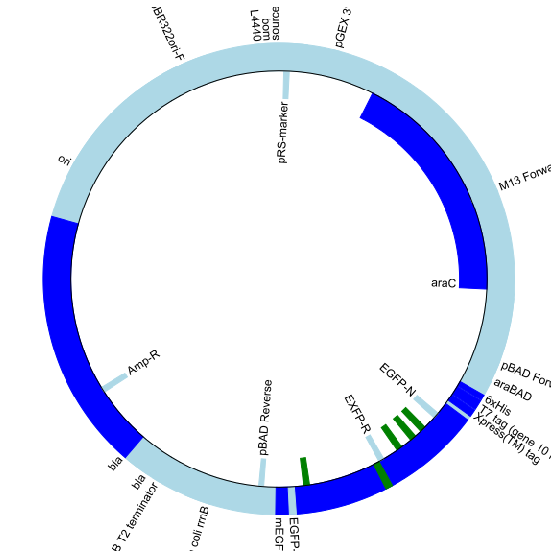

In [9]:
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO

gd_diagram = GenomeDiagram.Diagram("AddGene Plasmid")
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

for feature in plasmid.features:
    if feature.type == 'CDS':
        # Label genes in Blue
        color = colors.blue
    elif 'spacer' in feature.qualifiers:
        # Label gRNAs in Green
        color = colors.green
    else:
        # Everything else in Light Blue
        color = colors.lightblue
    gd_feature_set.add_feature(feature, color=color,
                               label=True, label_size=12)



gd_diagram.draw(format="circular",  pagesize=(20*cm,20*cm),
                fragments=4, start=0, end=len(plasmid), circle_core=0.7)

gd_diagram.write("plasmid_circular.png", "png")

fig, ax = plt.subplots(1,1, figsize= (10, 10))

img = plt.imread("plasmid_circular.png")
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])
sbn.despine(ax=ax, left=True, bottom=True)